In [18]:
import pynbody
import glob

import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../util/')
from util import util

## Get Our Galaxies

In [19]:
currentGals = util.getGalaxies()[0]

## Lookback Time and Redshift

In [20]:
gal = currentGals[0]
cdmFile = util.getfilepath(gal)[0]+ '/r'+str(gal)+'.romulus25.3072g1HsbBH.004096'

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()

hCDM = sCDM.halos(write_fpos=False)[1]

pynbody.analysis.angmom.faceon(hCDM)

cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

In [21]:
#sCDM.properties['boxsize'] = 2.5e4

In [22]:
sCDM.properties['boxsize']

Unit("2.50e+04 kpc")

In [23]:
pynbody.analysis.cosmology.age(sCDM)

13.800820457603765

## Half Mass Radius (Stellar Mass)

Call the function twice for an accurate measurement. First with coarse steps and low accuracy and then again with finer steps and accuracy using 90% of the first measurement as a starting point

In [24]:
# input: a simulation 
# output: half mass radius of that simulation
def halfMassRadius(sim, startR, incBy, acc):
    pRadii = np.array(sim.s['r'])
    pMass = np.array(sim.s['mass'])
    mTot = sum(pMass)
    
    # start at 5 kpc and increment
    r = startR-incBy
    hm = mTot
    while(hm < (0.50-acc)*mTot or hm > (0.5+acc)*mTot):
        r += incBy
        hm = sum(pMass[pRadii < r])
        
        if (r>max(pRadii)):
            return -1
        
    return r

In [25]:
halfMassRadius(sCDM, 0, 1, 0.1)

3

In [26]:
halfMassRadius(sCDM,2,0.05,0.01)

2.849999999999997

## sigma_gas
From Hirtenstein (2019): HII regions within 100 PC of young stars (10MYR); calculate density weghted dispersion. Median over 100 lines of sight 

In [27]:
sCDM['H2']

SimArray([5.e-13, 5.e-13, 5.e-13, ..., 0.e+00, 0.e+00, 0.e+00],
         dtype=float32)

In [28]:
sCDM['pos']

SimArray([[ 1.64062444e+03, -1.74213870e+03, -1.65957617e+03],
          [ 4.42786370e+02, -1.02821935e+03, -1.35912648e+03],
          [ 6.19598084e+02, -1.04668156e+03, -8.57752596e+02],
          ...,
          [-1.60686801e+00,  8.04683085e+00, -9.32106562e-01],
          [-8.96595639e+00,  2.03968476e+00, -6.31504702e-01],
          [-9.64827340e+00,  1.61920923e+00,  3.14472328e-01]], 'kpc')

In [29]:
len(sCDM.s['pos'][sCDM.s['age'].in_units('Myr')<10])

2772

In [30]:
youngstarPos = sCDM.s['pos'][sCDM.s['age'].in_units('Myr')<10]
HIIpos = sCDM.g['pos']

In [31]:
pynbody.snapshot.tipsy.HII(sCDM.g)

SimArray([ 7.63956096e-01,  7.63957387e-01,  7.63991614e-01, ...,
          -1.73698522e-09,  5.29173979e-01, -1.57068238e-08])

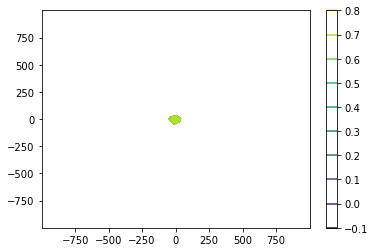

In [44]:
# contour to find HII regions
x = sCDM.g['pos'][:,0]
y = sCDM.g['pos'][:,1]
z = sCDM.g['pos'][:,2]

poslim = 1000

hii = sCDM.g['HII'][abs(x)<poslim]
z = z[abs(x)<poslim]
y = y[abs(x)<poslim]
x = x[abs(x)<poslim]

hii = hii[abs(y)<poslim]
z = z[abs(y)<poslim]
x = x[abs(y)<poslim]
y = y[abs(y)<poslim]

hii = hii[abs(z)<poslim]
x = x[abs(z)<poslim]
y = y[abs(z)<poslim]
z = z[abs(z)<poslim]

trc = plt.tricontour(x,y,hii)
plt.colorbar()

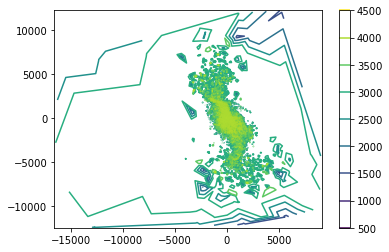

In [47]:
# contour gas mass 
x = sCDM.g['pos'][:,0]
y = sCDM.g['pos'][:,1]
z = sCDM.g['pos'][:,2]

gmass = sCDM.g['mass']

plt.tricontour(x,y,gmass)
plt.colorbar()

(array([ 709502.,  230169.,  224770.,  209074.,  154251.,  123438.,
         104014.,   94896.,  100339., 4764337.]),
 array([-3.11682246e-08,  7.63999719e-02,  1.52799975e-01,  2.29199978e-01,
         3.05599981e-01,  3.81999984e-01,  4.58399987e-01,  5.34799991e-01,
         6.11199994e-01,  6.87599997e-01,  7.64000000e-01]),
 <BarContainer object of 10 artists>)

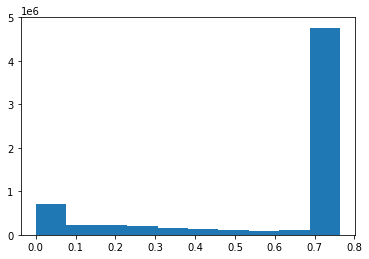

In [35]:
plt.hist(sCDM.g['HII'])

In [38]:
min(sCDM.g['HII'])

-3.116822455684343e-08

## Need to Navigate the Folders of Emu

* Given a halo number
* navigate to each sim file and open it
* acquire desired categories

In [58]:
sCDM.s['age'].in_units('Myr')

SimArray([1.35277645e+03, 1.34268115e+03, 1.34183987e+03, ...,
          6.40484514e-03, 6.40484514e-03, 6.40484514e-03], 'Myr')

In [21]:
sCDM.all_keys()

['HII',
 'HeIII',
 'ne',
 'hetot',
 'hydrogen',
 'feh',
 'oxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'c_s',
 'c_s_turb',
 'mjeans',
 'mjeans_turb',
 'ljeans',
 'ljeans_turb',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'v_curl',
 'vorticity',
 'v_div',
 'age',
 'u_mag',
 'u_lum_den',
 'b_mag',
 'b_lum_den',
 'v_mag',
 'v_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'j_mag',
 'j_lum_den',
 'h_mag',
 'h_lum_den',
 'k_mag',
 'k_lum_den',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tform',
 'iord_argsort',
 'smooth',
 'rho',
 'igasorder',
 'OxMassFracdot',
 'H2',
 'iord',
 'mass',
 'FeMassFrac',
 'tempEff',
 'massform',
 'rung',
 'eps',
 'den',
 'FeMassFra

In [14]:
def makeGalQtyCSV(gal, startTS=0):
    baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
    galDir = baseDir+ '/r' + str(gal)+'.romulus25.3072g1HsbBH'

    timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
    timesteps.sort(reverse=True)

    # setup file for exporting values
    outfile = '/home/jw1624/H1-merian/csvs/breathingModes/r'+str(gal)+'_qtys.txt'
    if startTS == 0:
        fout = open(outfile,'w')
        fout.write('galaxyID,timestep,t,z,')
        fout.write('M_star,R_halflight,R_halfmass,')
        fout.write('sigma_gas,sigma_star,')
        fout.write('SFR_10,SFR_100,sSFR_10,sSFR_100\n')
        fout.close()
    
    # iterate through each timestep
    for timestep in timesteps[startTS:]:
        fout = open(outfile, 'a')
        tstepnumber = timestep[-6:]

        # I'm assuming that if there's another subfolder, the sim is inside it

        # try to find sim file in current folder
        simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
        # check if there's another folder
        a=glob.glob(timestep+'/*/*')
        if len(a)>0:
            # find sim in folder
            simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
            simFile+= '/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
            #print(glob.glob(simFile)) 

        #print(glob.glob(simFile))
        # handle sim file not existing
        if len(glob.glob(simFile)) == 0:
            print('FNF for halo ' + str(gal) + ', timestep '+tstepnumber)
            continue

        # open simfile 
        sCDM = pynbody.load(simFile)

        sCDM.physical_units()
        
        # SFR and sSFR (do first otherwise we sometimes get an error)
        SFR_10  = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<10])
        SFR_100 = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<100])
        
        hCDM = -1
        try:
            hCDM = sCDM.halos(write_fpos=False)[1]
        except:
            # center manually if missing halo; taken from pynbody source code
            #print('HNF for halo ' + str(gal) + ', timestep '+str(tstepnumber))
            i = sCDM['phi'].argmin()
            cen_pot = sCDM['pos'][i].copy()
            sCDM['pos'] -= cen_pot
        else:
            hCDM = sCDM.halos(write_fpos=False)[1]
            cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
            sCDM['pos'] -= cen_pot
            
            pynbody.analysis.angmom.faceon(hCDM)

        # get age of universe
        uage = pynbody.analysis.cosmology.age(sCDM)
        # get redshift
        stepZ = pynbody.analysis.cosmology.redshift(sCDM, uage)

        # Mass
        mStar = sum(sCDM.s['mass'])

        # Sizes
        #rVir = pynbody.analysis.halo.virial_radius(sCDM)
        rHL = pynbody.analysis.luminosity.half_light_r(sCDM)

        rHM = halfMassRadius(sCDM, 0, 1, 0.1)
        rHM = halfMassRadius(sCDM,rHM*0.85, 0.05, 0.01)

        # velocity dispersion
        sCDM.properties['boxsize'] = 3.0e4
        sigma_gas = np.median(sCDM.g['v_disp'])
        sigma_star= np.median(sCDM.s['v_disp'])

        # sSFR
        sSFR_10 = SFR_10/mStar
        sSFR_100 = SFR_100/mStar

        # write to file
        fout.write(str(gal)+','+str(tstepnumber)+','+str(uage)+','+str(stepZ)+',')
        #fout.write(str(mStar)+','+str(rVir)+','+str(rHL)+','+str(rHM)+',')
        fout.write(str(mStar)+','+str(rHL)+','+str(rHM)+',')
        fout.write(str(sigma_gas)+','+str(sigma_star)+',')
        fout.write(str(SFR_10)+','+str(SFR_100)+','+str(sSFR_10)+','+str(sSFR_100)+'\n')

        fout.close()
        print('r'+str(gal)+' '+str(tstepnumber)+' done')

In [ ]:
for gal in currentGals[1:]:
    makeGalQtyCSV(gal)

r468 000069 done
r468 000096 done
r468 000105 done
r468 000136 done
r468 000186 done
r468 000192 done
r468 000223 done
r468 000273 done
r468 000288 done
r468 000345 done
r468 000384 done
r468 000454 done
r468 000480 done
r468 000576 done
r468 000635 done
r468 000672 done
r468 000768 done
r468 000775 done
r468 000864 done
r468 000960 done
r468 000972 done
r468 001056 done
r468 001104 done
r468 001152 done
r468 001248 done
r468 001268 done
r468 001344 done
r468 001440 done
r468 001474 done
r468 001536 done
r468 001632 done
r468 001728 done
r468 001739 done
r468 001824 done
r468 001920 done


## Single Timestep Investigating

In [3]:
gal = currentGals[0]

baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
galDir = baseDir+ '/r' + str(gal)+'.romulus25.3072g1HsbBH'

timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
timesteps.sort(reverse=True)
timesteps

['/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.004096',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.004032',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003936',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003840',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003744',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003648',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003606',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003552',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003456',
 '/data/RE

In [19]:
timestep = timesteps[-13]
tstepnumber = timestep[-6:]

# try to find sim file in current folder
simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
# check if there's another folder
a=glob.glob(timestep+'/*/*')
if len(a)>0:
    # find sim in folder
    simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
    simFile+= '/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
    #print(glob.glob(simFile)) 

#print(glob.glob(simFile))
# handle sim file not existing
if len(glob.glob(simFile)) == 0:
    print('FNF for halo ' + str(gal) + ', timestep '+tstepnumber)

# open simfile 
sCDM = pynbody.load(simFile)

sCDM.physical_units()

# SFR and sSFR (do first otherwise we sometimes get an error)
SFR_10  = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<10])
SFR_100 = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<100])

hCDM = -1

/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


In [20]:
hCDM = -1
try:
    hCDM = sCDM.halos(write_fpos=False)[1]
except:
    # center manually if missing halo; taken from pynbody source code
    #print('HNF for halo ' + str(gal) + ', timestep '+str(tstepnumber))
    print('doing manual centering')
    i = sCDM['phi'].argmin()
    cen_pot = sCDM['pos'][i].copy()
    sCDM['pos'] -= cen_pot
else:
    hCDM = sCDM.halos(write_fpos=False)[1]
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot

    pynbody.analysis.angmom.faceon(hCDM)

doing manual centering


In [22]:
# get age of universe
uage = pynbody.analysis.cosmology.age(sCDM)
# get redshift
stepZ = pynbody.analysis.cosmology.redshift(sCDM, uage)

# Mass
mStar = sum(sCDM.s['mass'])

# Sizes
#rVir = pynbody.analysis.halo.virial_radius(sCDM)
rHL = pynbody.analysis.luminosity.half_light_r(sCDM)

/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'a'=1.00e+00
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'h'=6.78e-01
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaM0'=3.09e-01
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaL0'=6.91e-01
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(


In [23]:
rHL

SimArray(0.34249912, 'kpc')

In [24]:
tstepnumber

'001152'

In [26]:
uage

13.795660358777317